# Mutual Information Analysis
This script analyzes the connections selected by mutual information (MI).

## Get Data

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style("whitegrid")

In [2]:
from common.data import get_data

X, Y, ages = get_data()

print("X shape:", X.shape, "Y shape:", len(Y.keys()))

X shape: (577, 34716) Y shape: 16


In [3]:
selected_measure = "WISC_FSIQ"
y = np.array(Y[selected_measure])

In [4]:
from common.age_bin import bin_by_age

bin_1, bin_2, bin_3 = bin_by_age(X, y, ages)

print("Bin 1:", len(bin_1.X), "|", "Bin 2:", len(bin_2.X), "|", "Bin 3:", len(bin_3.X))

Bin 1: 175 | Bin 2: 202 | Bin 3: 200


## Plot Connections

In [5]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from common.plotting import plot_connections

**MI Connections (All Ages)**

In [6]:
mi = SelectKBest(mutual_info_regression, k=1500)
X_mi = mi.fit_transform(X, y)
print("X_mi shape:", X_mi.shape)

X_mi shape: (577, 1500)


0 1


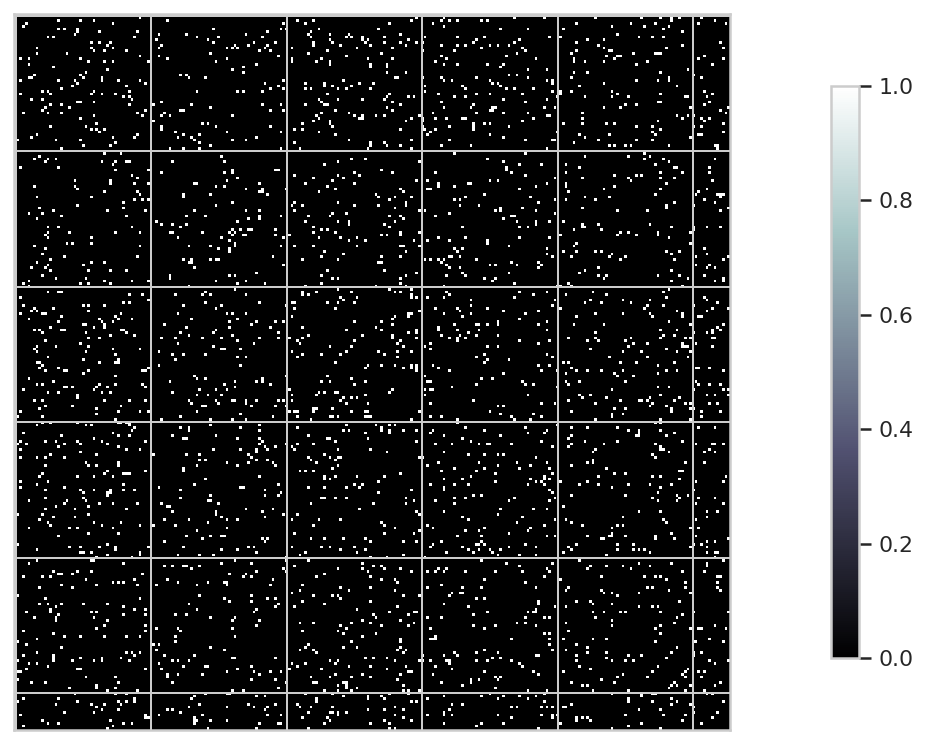

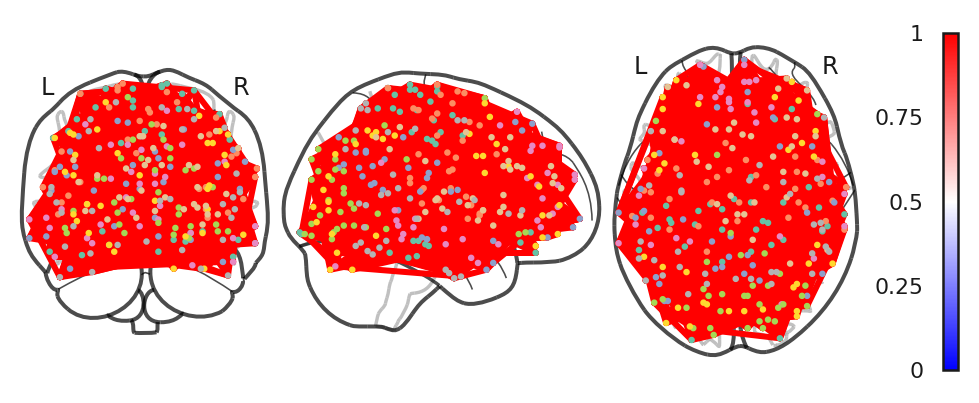

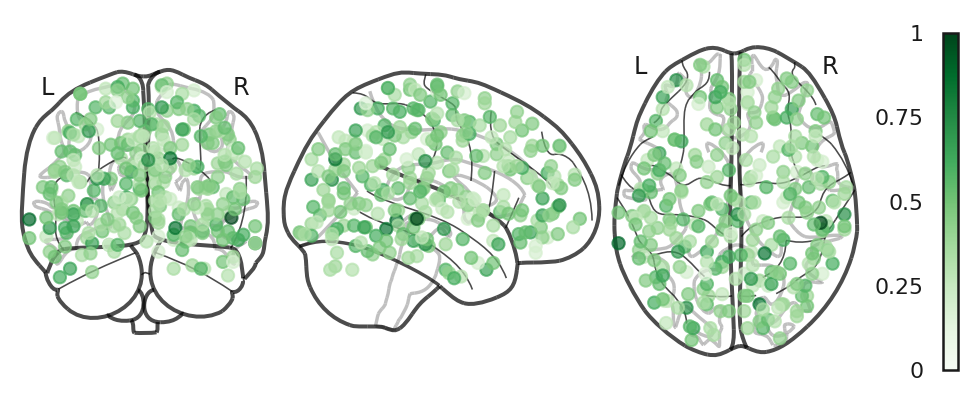

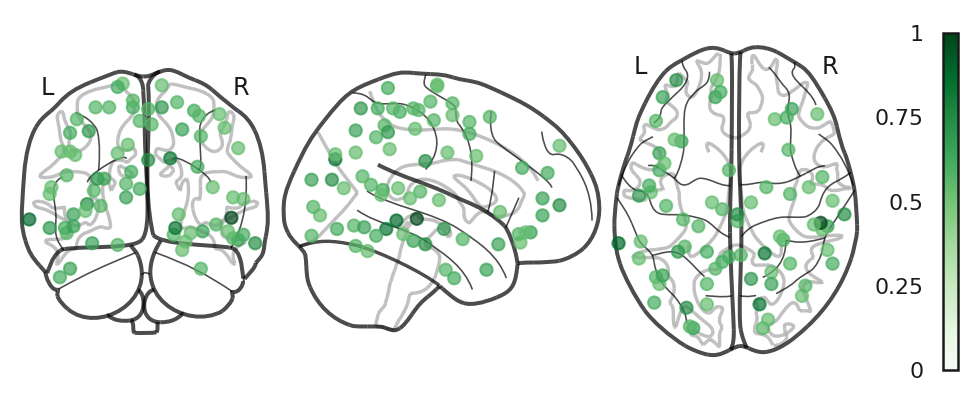

In [7]:
selected_features = mi.get_support().astype('int')
print(np.min(selected_features), np.max(selected_features))
# plot_connections(selected_features, 0, 1, mi_mode=True)

**MI Connections (Age Bins)**

In [8]:
mi_bin_1 = SelectKBest(mutual_info_regression, k=2500)
X_bin_1_mi = mi_bin_1.fit_transform(bin_1.X, bin_1.y)

mi_bin_2 = SelectKBest(mutual_info_regression, k=2000)
X_bin_2_mi = mi_bin_2.fit_transform(bin_2.X, bin_2.y)

mi_bin_3 = SelectKBest(mutual_info_regression, k=500)
X_bin_3_mi = mi_bin_3.fit_transform(bin_3.X, bin_3.y)

print("X_bin_1 shape:", X_bin_1_mi.shape,
      "X_bin_2 shape:", X_bin_2_mi.shape,
      "X_bin_3 shape:", X_bin_3_mi.shape)

X_bin_1 shape: (175, 2500) X_bin_2 shape: (202, 2000) X_bin_3 shape: (200, 500)


In [9]:
selected_features_bin_1 = mi_bin_1.get_support().astype('int')
selected_features_bin_2 = mi_bin_2.get_support().astype('int')
selected_features_bin_3 = mi_bin_3.get_support().astype('int')
# plot_connections(selected_features_bin)

**Overlapping Connections Between All and Bin Ages**

In [10]:
from common.calculation import multiply, compare_age_similarity
from common.plotting import plot_connections

In [11]:
overlaps = compare_age_similarity(selected_features, selected_features_bin_1, 
                                 selected_features_bin_2, selected_features_bin_3, multiply)
print([len(overlap[overlap == 1]) for overlap in overlaps])

# for overlap in overlaps:
#     plot_connections(overlap, vmin=0, vmax=1, mi_mode=True)

[197, 202, 59, 145, 30, 35]


**Overlapping Connections Between Overlaps**

In [14]:
for start in range(0, len(overlaps)):
    overlap_overlaps = []
    for other_overlap in overlaps[start:]:
        overlap_overlap = multiply(overlaps[start], other_overlap)
        overlap_overlaps.append(overlap_overlap)
    print([len(overlap[overlap == 1]) for overlap in overlap_overlaps])

[197, 23, 4, 23, 4, 0]
[202, 7, 23, 0, 7]
[59, 0, 4, 7]
[145, 3, 3]
[30, 3]
[35]


**Calculate the locations in the Powers atlas with the greatest node strengths**

In [ ]:
num_nodes = 3
node_strength = np.sum(np.abs(fc), axis=0)
node_strength /= np.max(node_strength)
highest_nodes = np.argpartition(
    node_strength, -num_nodes)[-num_nodes:]

print(coords[highest_nodes])

## Hyperparameter Search

In [6]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

In [59]:
train_scores = []
test_scores = []

for k in range(500, 6000, 500):
    y_k = bin_3.y
    X_k = SelectKBest(mutual_info_regression, k=k).fit_transform(
        bin_3.X, y_k)
    
    train_k = []
    test_k = []

    for i in range(0, 1000):
        X_train, X_test, y_train, y_test = train_test_split(
            X_k, y_k, test_size=0.3)

        pls = PLSRegression(n_components=2)
        pls.fit(X_train, y_train)

        train_k.append(pls.score(X_train, y_train))
        test_k.append(pls.score(X_test, y_test))

    train_scores.append(np.mean(train_k))
    test_scores.append(np.mean(test_k))

avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)

print("Train r^2:", avg_train_score)
print("Test r^2:", avg_test_score)

Train r^2: 0.5106735013458551
Test r^2: -0.009622149858269934


2000 0.007209978127400992


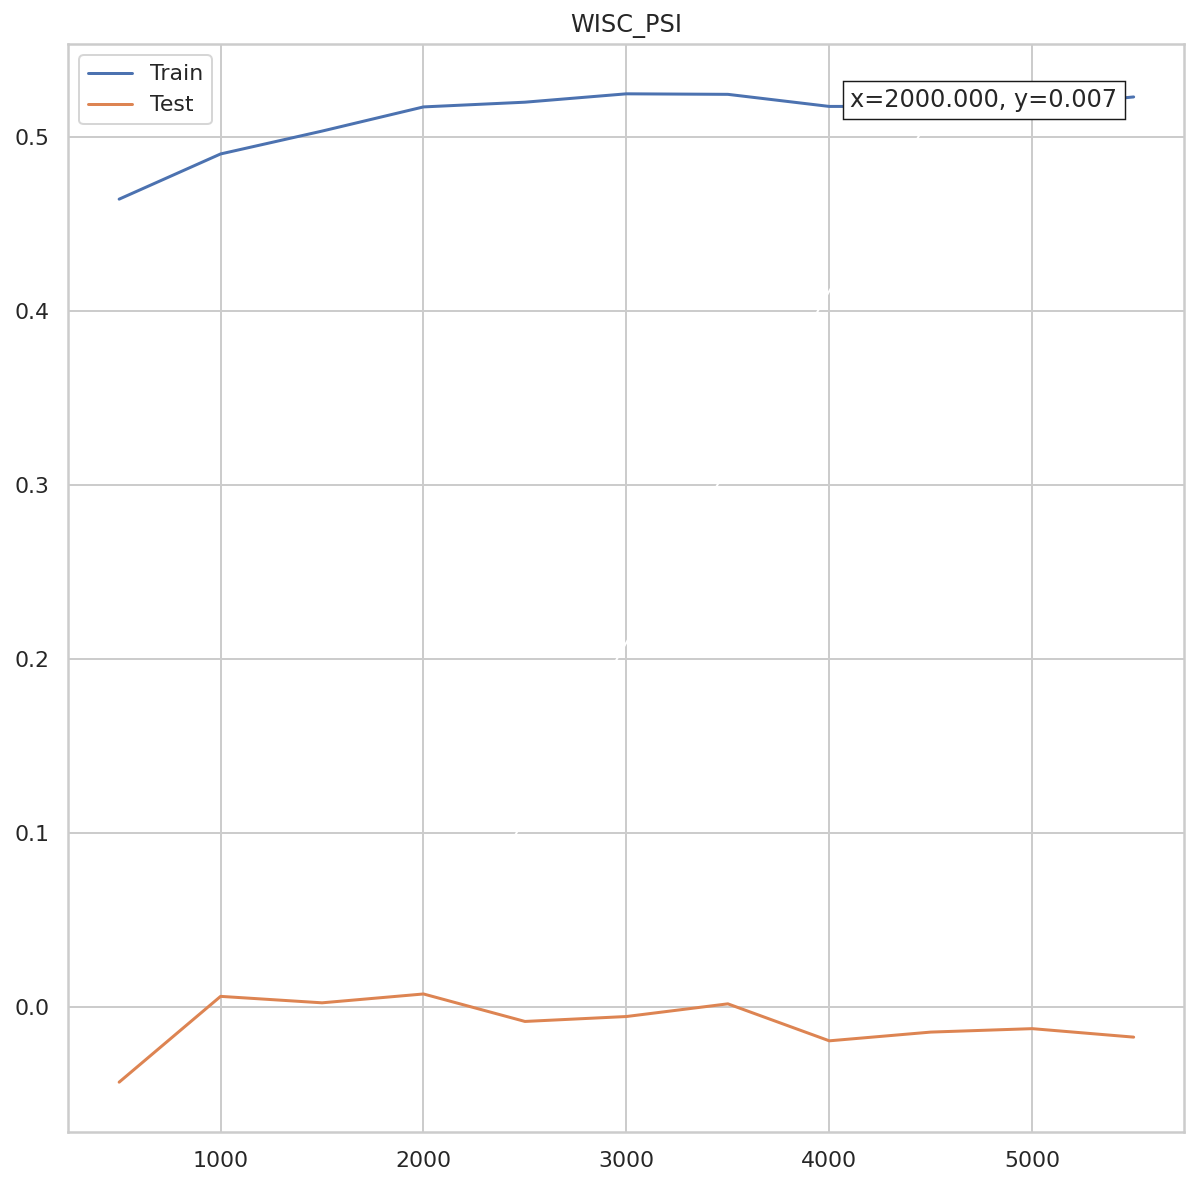

In [60]:
x_axis = range(500, 6000, 500)

plt.figure(1, figsize=(10, 10))
plt.title(selected_measure)
plt.plot(x_axis, train_scores, label="Train")
plt.plot(x_axis, test_scores, label="Test")
plt.legend()

def annot_max(x, y):
    xmax = x[np.argmax(y)]
    ymax = np.amax(y)
    print(xmax, ymax)
    text = "x={:.3f}, y={:.3f}".format(xmax, ymax)
    ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x_axis, test_scores)

plt.show()